[View in Colaboratory](https://colab.research.google.com/github/TharinduMalith/SpatioAE/blob/master/trainae.ipynb)

In [1]:
!git clone https://github.com/MChamith/SpatioAE

Cloning into 'SpatioAE'...
remote: Counting objects: 7165, done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 7165 (delta 11), reused 6 (delta 2), pack-reused 7142
Receiving objects: 100% (7165/7165), 275.44 MiB | 28.40 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Checking out files: 100% (7205/7205), done.


In [0]:
import os
os.chdir('SpatioAE')
!pwd
!git pull https://github.com/MChamith/SpatioAE
os.chdir('/content')  
!pwd

FileNotFoundError: ignored

In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8.1) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [4]:

from keras.layers import Input, Dense, Conv3D, MaxPooling3D, UpSampling3D, Activation, BatchNormalization
from keras.models import Model
from keras.preprocessing import image
from keras import backend as K
import cv2
import numpy as np
import os
from tqdm import tqdm
import fnmatch
import scipy.misc
from keras.models import load_model

Using TensorFlow backend.


In [0]:

from keras.layers import Input, Dense, Conv3D, MaxPooling3D, UpSampling3D, Activation, BatchNormalization
from keras.models import Model
from keras.preprocessing import image
from keras import backend as K
import cv2
import numpy as np
import os
from tqdm import tqdm
import fnmatch
import scipy.misc
from keras.models import load_model

TRAIN_DIR ='SpatioAE/Train'
TEST_DIR = 'SpatioAE/Test'
IMG_SIZE = 128



def create_training_set():
  train_data = []
  matches = []
  for root, dirnames, filenames in tqdm(os.walk(TRAIN_DIR)):
    for filename in fnmatch.filter(filenames, "*.tif"):
      path = os.path.join(root, filename)
      img = image.load_img(path, target_size=(128,128), grayscale = True)
      img_array = image.img_to_array(img)
#       print("img array size is " + str(img_array.shape))
#       img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE) )
#       img_array = np.expand_dims(img_array, axis = 2)
      train_data.append(np.array(img_array))
          
  np.save('training_data.npy' , train_data)
  
  return train_data

      
    
    
#   for img in tqdm(os.listdir(TRAIN_DIR)):
#     path = os.path.join(TRAIN_DIR, img)
#     img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE) )
#     img = np.expand_dims(img, axis = 2)
#     train_data.append(np.array(img))
    
    
#   np.save('training_data.npy' , train_data)
  
#   return train_data


def create_test_set():
  test_data = []
  for img in tqdm(os.listdir(TEST_DIR)):
    path = os.path.join(TEST_DIR, img)
    img = image.load_img(path, target_size=(128,128), grayscale = True)
    img_array =image.img_to_array(img)
    
#     img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE) )
#     img = np.expand_dims(img, axis = 2)
    test_data.append(np.array(img_array))
    
    
  np.save('test_data.npy' , test_data)
  return test_data

In [0]:
def create_cuboid(input_imgs):
  
  win_size = 4
  m = input_imgs.shape[0]
  h = input_imgs.shape[1]
  w = input_imgs.shape[2]
  c = input_imgs.shape[3]
  
  a = []                                    # a python list to hold the windows
  for i in range(0, input_imgs.shape[0]-win_size+1):
    window = input_imgs[i:i+win_size,:,:,:].reshape((-1,h,w,c)) # each individual window
    a.append(window)
    print('i = ' + str(i))
   
#   cuboid = np.hstack(a)
  np.save('hyper_cuboid_win4.npy' , a)
  return a

  
  

In [0]:
def create_test_cuboid(input_imgs):
  
  win_size = 4
  m = input_imgs.shape[0]
  h = input_imgs.shape[1]
  w = input_imgs.shape[2]
  c = input_imgs.shape[3]
  
  t = []                                    # a python list to hold the windows
  for i in range(0, input_imgs.shape[0]-win_size+1):
    window = input_imgs[i:i+win_size,:,:,:].reshape((-1,h,w,c)) # each individual window
    t.append(window)
   
#   cuboid = np.hstack(a)
  np.save('test_hyper_cuboid_win4.npy' , t)
  return t

In [8]:
create_training_set()
print('started')
input_data = np.load('training_data.npy')
print('training data loaded')
input_data = input_data.astype('float32') / 255
print('data normalized')
create_cuboid(input_data)
print('cuboid created')
img_cuboids = np.load('hyper_cuboid_win4.npy')
print(img_cuboids.shape)


35it [00:06,  5.25it/s]


started
training data loaded
data normalized
i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i = 27
i = 28
i = 29
i = 30
i = 31
i = 32
i = 33
i = 34
i = 35
i = 36
i = 37
i = 38
i = 39
i = 40
i = 41
i = 42
i = 43
i = 44
i = 45
i = 46
i = 47
i = 48
i = 49
i = 50
i = 51
i = 52
i = 53
i = 54
i = 55
i = 56
i = 57
i = 58
i = 59
i = 60
i = 61
i = 62
i = 63
i = 64
i = 65
i = 66
i = 67
i = 68
i = 69
i = 70
i = 71
i = 72
i = 73
i = 74
i = 75
i = 76
i = 77
i = 78
i = 79
i = 80
i = 81
i = 82
i = 83
i = 84
i = 85
i = 86
i = 87
i = 88
i = 89
i = 90
i = 91
i = 92
i = 93
i = 94
i = 95
i = 96
i = 97
i = 98
i = 99
i = 100
i = 101
i = 102
i = 103
i = 104
i = 105
i = 106
i = 107
i = 108
i = 109
i = 110
i = 111
i = 112
i = 113
i = 114
i = 115
i = 116
i = 117
i = 118
i = 119
i = 120
i = 121
i = 122
i = 123
i = 124
i = 125
i = 126
i = 127
i = 128
i = 129
i = 130
i = 131
i = 132
i

In [0]:
input_data = np.load('drive/Data/training_data.npy')

In [0]:

input_data = input_data.astype('float32') / 255.
create_cuboid(input_data)

In [18]:
print(img_cuboids.shape)

(6785, 16, 128, 128, 1)


In [9]:
print(img_cuboids.shape)

(6785, 16, 128, 128, 1)


In [0]:

def model_autoencoder():
  
  input_img  = Input(shape = (4,128,128,1))  #channel last
  
  x = Conv3D(filters = 32, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(input_img)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  x = MaxPooling3D(pool_size = (2,2,2), strides = (2,2,2))(x)
  print("layer one conv " + str(x.shape))
  
  x = Conv3D(filters = 48, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  x = MaxPooling3D(pool_size = (2,2,2), strides = (2,2,2))(x)
  print("layer two conv " + str(x.shape))
  
 
  x = Conv3D(filters = 64, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  x = MaxPooling3D(pool_size = (1,2,2), strides = (2,2,2), padding= 'same')(x)
  print("layer three conv " + str(x.shape))
  
  x = Conv3D(filters = 64, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  encoded = MaxPooling3D(pool_size = (1,1,1), strides = (1,1,1))(x)
  print("layer four conv " + str(encoded.shape))
  
  
  ## decoder branch
  
  x = Conv3D(filters = 48, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(encoded)
  x = UpSampling3D(size = (2,2,2))(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  print("layer one deconv " + str(x.shape))
 
  x = Conv3D(filters = 32, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(x)
  x = UpSampling3D(size = (2,2,2))(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  print("layer two deconv " + str(x.shape))
  
  x = Conv3D(filters = 32, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(x)
  x = UpSampling3D(size = (1,2,2))(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  print("layer three deconv " + str(x.shape))
  decoded = Conv3D(filters = 1, kernel_size = (3,3,3), strides = (1,1,1), padding = 'same', activation = 'sigmoid')(x)
  print("output" + str(decoded.shape))

  
  
  autoencoder = Model(input_img, decoded)
  
  return autoencoder
  

In [0]:
os.chdir('SpatioAE')
!pwd
!git config --global user.email "charmiemawela02@gmail.com"
!git config --global user.name "MChamith"
!git add hyper_cuboid.npy
!git commit -m "hyper cuboid"
!git push origin master
!pwd
os.chdir('/content')  
!pwd


In [14]:
# create_training_set()
# input_imgs = np.load('training_data.npy')
# create_cuboid(input_imgs)
img_cuboids = np.load('hyper_cuboid_win4.npy')
print("hyper cuboid loaded")
# img_cuboids = img_cuboids.astype('float32') / 255.
print("data normalized")
K.clear_session()
autoencoder = model_autoencoder()
autoencoder.compile(optimizer = 'adam' , loss = 'mean_squared_error')
print("model compiled")
autoencoder.fit(img_cuboids,img_cuboids,  epochs =10, batch_size= 16)
print("model fitted")
  
    

hyper cuboid loaded
data normalized
layer one conv (?, 2, 64, 64, 32)
layer two conv (?, 1, 32, 32, 48)
layer three conv (?, 1, 16, 16, 64)
layer four conv (?, 1, 16, 16, 64)
layer one deconv (?, 2, 32, 32, 48)
layer two deconv (?, 4, 64, 64, 32)
layer three deconv (?, 4, 128, 128, 32)
output(?, 4, 128, 128, 1)
model compiled
Epoch 1/10
6797/6797 [==============================] - 233s 34ms/step - loss: 0.0054
Epoch 2/10
6797/6797 [==============================] - 229s 34ms/step - loss: 0.0034
Epoch 3/10
6797/6797 [==============================] - 228s 34ms/step - loss: 0.0028
Epoch 4/10
6797/6797 [==============================] - 227s 33ms/step - loss: 0.0025
Epoch 5/10
6797/6797 [==============================] - 227s 33ms/step - loss: 0.0023
Epoch 6/10
6797/6797 [==============================] - 228s 34ms/step - loss: 0.0022
Epoch 7/10
6797/6797 [==============================] - 228s 34ms/step - loss: 0.0020
Epoch 8/10
6797/6797 [==============================] - 227s 33ms/step

In [0]:
autoencoder.save('3d_autoencoder_model_iter1_win4.h5')



In [0]:
autoencoder.save('drive/Data/3d_autoencoder_model_iter1_win4.h5')

In [0]:
from keras.models import load_model 
autoencoder_model = load_model('drive/Data/3d_autoencoder_model_iter2.h5')
autoencoder_model.summary()

In [63]:
print(img_cuboids.shape)

(6785, 16, 128, 128, 1)


In [65]:
from keras.callbacks import Callback
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
history = LossHistory()        
img_cuboids = np.load('drive/Data/hyper_cuboid.npy')       
autoencoder_model.fit(img_cuboids,img_cuboids,  epochs =5, batch_size=4, callbacks=[history])  
autoencoder_model.save('drive/Data/3d_autoencoder_model_iter3.h5')

FileNotFoundError: ignored

In [0]:
autoencoder_model.save('3d_autoencoder_model_iter2.h5')


NameError: ignored

In [19]:
train_loss = np.array(history.losses)
# train_loss = train_loss[16965-6785:16965]
# train_loss_normed = np.linalg.norm(train_loss)
min_ex = min(train_loss)
max_ex = max(train_loss)

print('minimum loss = ' + str(min_ex) + 'maximum loss= ' + str(max_ex)+ 'train losss = '+str(train_loss.shape))

minimum loss = 0.0006428565maximum loss= 0.0050993245train losss = (1697,)


In [23]:
# get_test_data = create_test_set()
# test_imgs = np.load('drive/Data/test_data.npy')
# test_imgs = test_imgs.astype('float32') / 255.
# create_test_cuboid(test_imgs)
test_cuboid = np.load('drive/Data/test_hyper_cuboid.npy')

print(test_cuboid.shape)




(185, 16, 128, 128, 1)


In [0]:
decode_imgs = autoencoder_model.predict(test_cuboid)

In [25]:
print(decode_imgs.shape)

(185, 16, 128, 128, 1)


In [0]:
real_img = np.load('drive/Data/test_data.npy')

In [0]:
def calculate_costs(img_size, win_size):
  
  input_size = img_size+win_size
  costs = np.zeros(img_size+win_size-1, dtype= float)
#   if img_size+win_size > num_input:
#     break
    
  for i in range(0, img_size):
    for k in range(win_size):
      temp = np.squeeze(decode_imgs[i][k])-np.squeeze(test_cuboid[1][2])
      costs[i+k]= np.linalg.norm(temp)
			
  
  np.save('drive/Data/test_costs_new.npy',costs)
  return costs
    
  
  
  
  

In [49]:
print(np.linalg.norm(np.squeeze(decode_imgs[1][2])-np.squeeze(test_cuboid[1][2])))

7.740723


In [56]:
calculate_costs(test_cuboid.shape[0],16)
cost_val = np.load('drive/Data/test_costs_new.npy')
print(cost_val[114])


10.608013153076172


In [58]:
print(cost_val)

[10.98891163 15.01766205 14.52577209  7.57727432 15.10706329 10.74244308
 12.87235069  9.5606966  15.08488846 15.36161613 13.97982216 14.89676094
 14.9264679  14.167202   15.00793743 14.38681984 11.11405182 14.85769367
 13.91903114 13.70259094 14.08737183 15.58161449 14.59569073 12.86972523
 15.05270863 14.90626526 14.56619644  8.1476202  15.76069736 12.31843567
 14.30083942 13.80075455 14.72713852 14.86004448 15.0462532  10.97443771
 13.90947628 13.90060043 14.61499405 14.2467823  14.78143597 14.54149628
 14.870574   14.96071148 15.91969776 14.33840275 15.3761282  13.33113194
 14.60479546 15.04526424 14.46797848 15.18430901 15.08746719 13.72343063
 14.96550941 15.1945076  15.11062813 15.34947968 13.1603241  13.62597656
 15.9060297  14.65037441 14.85596657 13.46414471 15.2412262  13.91477776
 15.63109016 13.58391666 13.45775127 15.30047703 15.36619186 14.95969963
 15.75593376 14.69528961 14.83323097 14.7902956  13.97977638  9.30869675
 15.43408775 14.73176193 12.77324009 13.50435829 14

In [59]:

score = cost_val - min(cost_val)
score = 1 - (score/max(cost_val))
print('maximum score = ' +str(max(score))+ 'min score = ' + str(min(score)))

maximum score = 1.0min score = 0.4759684785484801


In [60]:
print(score)

[0.78569711 0.53263009 0.56352829 1.         0.52701433 0.80117909
 0.66738839 0.87541081 0.52840724 0.51102452 0.59782227 0.54022452
 0.53835847 0.58605196 0.53324094 0.57225661 0.77783639 0.54267854
 0.60164088 0.61523663 0.59106651 0.49720527 0.55913633 0.66755331
 0.53042863 0.53962751 0.56098902 0.96417357 0.48595613 0.7021827
 0.57765749 0.60907045 0.5508794  0.54253088 0.53083413 0.78660629
 0.60224107 0.60279861 0.55792379 0.5810531  0.54746869 0.56254057
 0.54186946 0.53620745 0.47596848 0.57529794 0.51011294 0.63856992
 0.55856441 0.53089625 0.56715861 0.52216212 0.52824526 0.61392758
 0.53590607 0.52152149 0.5267904  0.51178688 0.64929926 0.62004918
 0.47682704 0.55570136 0.54278703 0.63021469 0.51858685 0.60190806
 0.49409744 0.62269118 0.63061629 0.51486499 0.5107371  0.53627101
 0.48625536 0.55288    0.54421518 0.54691217 0.59782515 0.89124025
 0.5064722  0.55058898 0.67361404 0.62768866 0.57349563 0.97104232
 0.53112131 0.4926445  0.56203934 0.79927949 0.59969264 0.51396

In [0]:
import matplotlib.pyplot as plt
from PIL import Image

for n in range(10):
  sq_img = np.squeeze(test_cuboid[n][1], axis = 2)
  sq_img = sq_img*255
  sq_img = sq_img.astype('uint8')

  dec_img = np.squeeze(decode_imgs[n][1], axis = 2)
  dec_img = dec_img*255
  dec_img = dec_img.astype('uint8')

  scipy.misc.imsave('testimage'+str(n)+'.png', sq_img)
  scipy.misc.imsave('dec'+str(n)+'.png', dec_img)


# plt.imshow(sq_img)

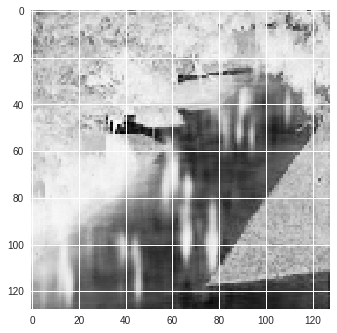

In [52]:
plt.imshow(np.squeeze(decode_imgs[1][1], axis = 2))
  

In [50]:
autoencoder_model.evaluate(test_cuboid, test_cuboid)


185/185 [==============================] - 9s 47ms/step


0.003747839407642951

In [0]:
import pydot
import graphviz
from keras.utils import plot_model
plot_model(autoencoder, to_file='model.png',show_shapes=True)

In [0]:
!apt-get install -q graphviz

Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.38.0-16ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
